!conda install --file /content/drive/MyDrive/GitHub/Pytorch-Geometric-Neural-Automata/requirements.txt
import sys
sys.path.insert(0,'/content/drive/MyDrive/GitHub/Pytorch-Geometric-Neural-Automata/')

In [1]:

# conda install pytorch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -c pytorch -y & conda install pyg -c pyg -y & conda install -c anaconda networkx -y & conda install -c conda-forge matplotlib -y
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils
from utils import *
from model import UpdateRule
from datasets import *


In [2]:
class D():
    def __init__(self, datasets):
        self.datasets = datasets
        # self.datasets = [Dataset(data=torch.tensor([[0,1,0]]), target=torch.tensor([[0,1,0]]))]#, TranslateDataset(1, n=n)]
        
        self.batch_size = 1
    
    def __iter__(self):
        # for problem_x, problem_y in zip(TDataset1().data, TDataset2().data), zip(TDataset1().target, TDataset2().target):
        
        new_idx = torch.randperm(len(self.datasets))
        self.datasets = [self.datasets[i].shuffle() for i in new_idx]
        
        datasets_in_batch = [self.datasets[i % len(self.datasets)].shuffle() for i in range(self.batch_size)]
        
        for x in zip(*([d.data for d in datasets_in_batch] + [d.target for d in datasets_in_batch])):
            yield torch.stack(x[0:len(datasets_in_batch)]), torch.stack(x[len(datasets_in_batch):])
            
    def __len__(self):
        return len(self.datasets)
    
    def iterate(self):
        """
        returns a generator that gives an shuffled index
        """
        self.init()
        return iter(torch.randperm(len(self.datasets)))

    @property
    def n_inputs(self):
        return self.datasets[0].data.shape[1]

    @property
    def n_outputs(self):
        return self.datasets[0].target.shape[1]
    

c:\Users\lmacl\Google Drive\GitHub\Pytorch-Geometric-Neural-Automata\datasets.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data).to(cuda_device)
c:\Users\lmacl\Google Drive\GitHub\Pytorch-Geometric-Neural-Automata\datasets.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(target).to(cuda_device)


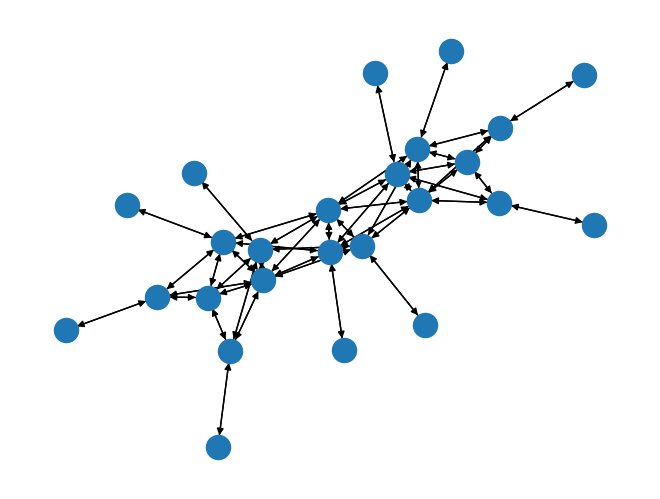

In [3]:

n= 5
training_set = D([
    TranslateDataset(0, n=n)#, TranslateDataset(2, n=n), TranslateDataset(-2, n=n), TranslateDataset(1, n=n)
])
# training_set = D([
#     Dataset(
#         [[0,1,0,1,0], [1,0,0,0,1], [1,0,1,0,0], [1,0,0,1,0]],
#         [[0,1,1,1,0], [1,1,1,1,1], [1,1,1,0,0], [1,1,1,1,0]]
#     ),
#     Dataset(
#         [[0,1,0,1,0], [1,1,0,0,0], [1,0,1,0,0], [1,0,0,1,0]],
#         [[0,1,0,1,0], [0,0,0,1,1], [0,0,1,0,1], [0,1,0,0,1]]
#     ),
#     TranslateDataset(0, n=n), TranslateDataset(2, n=n), TranslateDataset(-2, n=n), TranslateDataset(1, n=n)
# ])
# testing_set = D([
#     TranslateDataset(-1, n=n), 
#     Dataset(
#         [[1,0,1,0,0], [0,0,0,1,1], [0,0,1,0,1], [0,1,0,1,0]],
#         [[0,1,0,1,0], [1,0,0,0,1], [1,0,0,1,0], [0,0,1,0,1]]
#     ),
#     ])
# testing_set.batch_size = 2
testing_set = None

heads = 1
hidden_dim = 64
edge_dim = None
# edge_dim = 8

n_inputs = training_set.n_inputs
n_outputs = training_set.n_outputs
height = 3
width = training_set.n_inputs

cuda_device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
# cuda_device = torch.device("cpu")

update_rule = UpdateRule(
    n_inputs, 
    n_outputs,
    hidden_dim,
    edge_dim,
    network_width=hidden_dim,#hidden_dim,
    heads = heads,
    cuda_device=cuda_device
)
update_rule.build_graph(
    height,
    width,
    mode="dense",
    input_mode="grid",
)


update_rule = update_rule.to(cuda_device)
edge_attr = None

update_rule.draw()

#load initial_meta.pt
# update_rule.load_state_dict(torch.load("initial.pt", map_location=cuda_device))


In [4]:
from training import *
import time
n_steps = 4
batch_size = 5
training_set.batch_size = batch_size
lr = 0.001
optimizer = torch.optim.Adam(update_rule.parameters(), lr=lr)
use_wandb = True

wandb_name = "E4"
if use_wandb:
    wandb.init(
        project="Experiments",
        name=wandb_name,
        # resume=True,
        tags=["Translate(0)"]
        )
    # wandb.run.log_code(".")

start_time = time.time()
train_on_meta_set(
    update_rule, optimizer, training_set, testing_set, {
        "n_steps": n_steps,
        "batch_size": batch_size,
        "n_epochs": 30000000,
    }, edge_attr=edge_attr,# edge_index=best_edges,
    # wandb_loss = f"baseline loss",
    # wandb_acc = f"baseline acc",
    wandb_log = use_wandb,
    save_dir=None,#"Edge_Weight",
    last_idx = 3,
    device=cuda_device
)
# if use_wandb:
#     wandb.run.log_code(".")
#     wandb.finish()

print(f"Training took {time.time() - start_time} seconds")
assert False, "stop here"

  Epoch 0 | Loss 0.858593 | Accuracy 80% | Network out: [0.463 0.463 0.462 0.461 0.463] | Correct:  [0. 0. 1. 0. 0.] 
  Epoch 50 | Loss 0.843744 | Accuracy 80% | Network out: [0.427 0.419 0.432 0.443 0.444] | Correct:  [0. 0. 0. 0. 1.] 

KeyboardInterrupt: 

In [ ]:
#save update_rule
torch.save(update_rule.state_dict(), "initial.pt")

In [ ]:
#load Edge_Weight.pt
with open("Edge_Weight.pt", "rb") as f:
    update_rule.load_state_dict(torch.load(f))


x = update_rule.initial_state()
x, loss, network_output, correct, network_in = update_rule(
                    x, 1, DataLoader(TranslateDataset(0), shuffle=True), edge_attr=edge_attr
                )
print(loss, network_output, correct, network_in)

In [ ]:
import pygad
import pygad.torchga
from training import *
import torch
import time
import numpy as np


class EdgeModel(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.edge_mask = nn.Parameter(torch.zeros(
            [update_rule.graph.edge_index.shape[1]]).byte(), requires_grad=False)

    def get_edges(self):
        """
        Returns elements of update_rule.edge_index coressponding to the incidces of edge_mask > 0
        """
        # clamp edge mask to be between -1 and 1
        # self.edge_mask= nn.Parameter(self.edge_mask.clamp(-1, 1))

        return update_rule.edge_index[:, self.edge_mask > 0]


def fitness_func(solution, sol_idx):
    global edge_model
    np.clip(solution, -1, 1)
    model_weights_dict = pygad.torchga.model_weights_as_dict(
        model=edge_model, weights_vector=solution)
    edge_model.load_state_dict(model_weights_dict)

    update_rule = UpdateRule(
        n_inputs,
        n_outputs,
        hidden_dim,
        edge_dim,
        network_width=hidden_dim,
        heads=1
    )

    update_rule.build_graph(
        height,
        width,
        mode="dense"
    )
    optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.001)
    loss_integral = train_on_meta_set(
        update_rule, optimizer, training_set, {
            "n_steps": 1,
            "batch_size": 5,
            "n_epochs": 40,
        }, edge_attr=edge_attr, verbose=False, edge_index=edge_model.get_edges(), wandb_log=False
    )

    return -loss_integral.item()

best_edge_index = []

def callback_generation(ga_instance):
    global best_edge_index
    print("Generation = {}".format(ga_instance.generations_completed))

    if ga_instance.generations_completed % 10 == 0:
        best_sol = ga_instance.best_solution()
        print("Fitness    = {}".format(best_sol[1]))
        print(best_sol[0])
        best_edge_index = update_rule.edge_index[:, best_sol[0]]

        wandb.log({
            "fitness": best_sol[1],
        })
        with open("best_edge_index.txt", "w") as f:
            f.write(str(best_edge_index[0].tolist()))


edge_model = EdgeModel()

torch_ga = pygad.torchga.TorchGA(model=edge_model,
                                 num_solutions=10)
ga_instance = pygad.GA(num_generations=10000000,
                       num_parents_mating=5,
                       initial_population=torch_ga.population_weights,
                       fitness_func=fitness_func,
                       parent_selection_type="sss",
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_percent_genes=10,
                       keep_parents=-1,

                       # force binary weights
                       random_mutation_min_val=0,
                       random_mutation_max_val=2,
                       init_range_low=0,
                       init_range_high=2,
                       mutation_by_replacement=True,
                       gene_type=int,
                       #######

                       on_generation=callback_generation)



In [ ]:
wandb.init(project="neural-automata-evolve-on-meta-translate",
           name="Evolve edges",
           resume=True,
           )
wandb.run.log_code(".")
ga_instance.run()
wandb.finish()

ga_instance.save(filename="meta_edge_evo")

In [ ]:
ga_instance.save(filename="meta_edge_evo")

In [ ]:
# best_binary = "0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1".split(" ")
# best_binary  = """0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0
#  0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
#  0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0
#  0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0
#  1 0 1 0 0 0 0 1 1 1 1 0 0 1""".replace("\n", "").split(" ")

# best_binary = torch.tensor([int(x) for x in best_binary], dtype=torch.int)

# iterate through update_rule.edge_index. if the element contains a value > 10, set the corresponding element in best_binary to 1
# for i, edge in enumerate(update_rule.edge_index.T):
# if edge[0] >= 10 or edge[1] >= 10:
#     best_binary[i] = 1

#     if edge[0] < 10 and edge[1] < 10:
#         best_binary[i] = 1

best_binary = update_rule.get_edge_weight().squeeze()  # .round()
best_edges = update_rule.edge_index[:, best_binary > 0.2]


n_nodes = height*width + n_inputs + n_outputs
nodes = torch.zeros(n_nodes, 1)

color_map = ["blue"] * height*width + \
    ["green"] * n_inputs + ["red"] * n_outputs

# graph = Data(edge_index=best_edges, x=nodes)
graph = Data(edge_index=update_rule.edge_index, x=nodes, edge_attr=update_rule.get_edge_weight())
graph = utils.to_networkx(graph, to_undirected=False, remove_self_loops=False)

# iterate over graph.edges and check if in best_edges.T
edge_color = []
edge_styles = []
edge_labels = {}

for edge in graph.edges:
    if list(edge) not in list([list(x) for x in best_edges.T]):
        edge_color.append("blue")
        edge_styles.append("dashed")
    else:
        edge_color.append("red")
        edge_styles.append("solid")

    edge_labels[edge] = str(edge)

pos = nx.spring_layout(graph)
nx.draw(
    graph, pos, arrows=True, node_color=color_map, labels={i: i for i in range(n_nodes)}, edge_color=edge_color, style=edge_styles, arrowsize=13, font_color="whitesmoke",

)

# nx.draw_networkx_edge_labels(
#     graph, pos,
#     edge_labels=edge_labels
# )

plt.savefig("graph.png", dpi=300)


In [ ]:
graph.edges(data=True)

In [ ]:
import torch
# best_edge_index = torch.tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  1,  2,  0,  1,
#           2,  6,  6,  7,  8,  8,  8,  5,  5,  3,  9,  9, 10, 10, 11, 11,  0,  1,
#           3,  7,  8,  9, 10, 11],
#         [ 1,  4,  3,  5,  1,  5,  0,  1,  4,  0,  2,  5,  1,  2,  6,  6,  7,  7,
#           8,  1,  2,  0,  0,  1,  2, 10, 11, 11,  4,  3,  5,  4,  5,  3,  0,  1,
#           3,  7,  8,  9, 10, 11]])

best_binary = "0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1".split(" ")

update_rule.edge_index[:, best_binary[0]]

In [ ]:
import pickle

#pickle torch_ga

with open("torch_ga.pickle", "wb") as file:
    pickle.dump(torch_ga, file)
#Fitness    = -16.754362106323242

best_binary  = """0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0
 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0
 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0
 1 0 1 0 0 0 0 1 1 1 1 0 0 1""".replace("\n", "").split(" ")

In [ ]:
update_rule.edge_index[:, 42:]

In [ ]:
#normal distribution tensor
torch.randn(5, 1)



In [ ]:
!conda env export --no-builds > environment.yml


In [ ]:
torch.randn([5,1])


In [ ]:
from torch.nn.functional import one_hot

one_hot(torch.arange(4), 6).unsqueeze(0).repeat(2,1,1)

In [ ]:

b_size = 20
torch.concat((torch.zeros([b_size,7,32]), one_hot(torch.arange(7), 7).unsqueeze(0).repeat(b_size,1,1)), -1)

In [ ]:
import wandb
wandb.login()